## Tensorflow Probability - GeoNet Quake Data: Analysing Public Reports

In my previous notebook I downloaded a bunch of NZ earthquake data from Geonet. Geonet are great - there aren't many government departments that provide their data so freely and painlessly. Geonet provide simple search/download features on their website and also provide a REST API. So easy.

Today I am going to dig into the public report data. Specifically, I am going to look at the location that these reports come from. When I was downloading these data, I noticed that there are some very odd locations, as far away as Australia. 

In addition to these obvious anomalies, I suspect that there will be mis-reported locations as well. My suspicion is that Geonet use our IP address to approximate our location. There are all sorts of reasons that this can go wrong. I know that we often show up in Auckland or Wellington, despite being in Nelson. 

These location anomalies are interesting (from a data perspective). And I wonder whether I can identify these anomalies?

I will explore a number of assumptions about these data:  

  1. that earthquake reports cluster geographically and are more likely to occur near the epicenter of a quake.  
  2. that the number of reports and the intensity of reports decrease the futher from the epicenter someone is located  
  3. similar to above, "intensity" is probably related to geographical distance *and* the depth of an earthquake  

Finally, I also suspect that the official measurement coordinates correspond to the location of a seismic station and not the epicenter of the quake. To highlight this, have a look at the official measurements and notice the total lack of measurements from Auckland north and the incredible density of official measurements throughout the Central & Western regions of the North Island. This density corresponds to the same distribution of seismic station locations, which you can see on Geonet's website. I suspect that the "epicenter" of public reportings will not match the official coordinates.

### Setup  

We'll begin with the usual setup: make sure we have tfp 0.8.0 or higher, arviz and then create the MonteCarloEngine class.

In [0]:
! pip3 install -q --upgrade tensorflow-probability==0.8.0
! pip3 install -q arviz

In [3]:
import collections
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import arviz as az
import matplotlib.pyplot as plt
import daft as daft 

import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

try:
  tf.compat.v1.enable_eager_execution()
except ValueError:
  pass

from __future__ import print_function

class MonteCarloEngine:

    def __init__(self):
        self.session = None
        self.run = tf.function(
            self.sampler, autograph=False, experimental_compile=True
        )

    def reset_session(self, config = None):
        tf.reset_default_graph()

        try:
            self.session.close()
        except:
            pass

        self.session = tf.InteractiveSession(config = config)

    def trace_function(self, samples, pkr):
        return (
            pkr.inner_results.inner_results.target_log_prob,
            pkr.inner_results.inner_results.leapfrogs_taken,
            pkr.inner_results.inner_results.has_divergence,
            pkr.inner_results.inner_results.energy,
            pkr.inner_results.inner_results.log_accept_ratio
        )

    def get_trace_stats(self, trace, statnames = ['log_likelihood', 'tree_size', 'diverging', 'energy', 'mean_tree_accept']):
      return az.from_dict(sample_stats = {k:v.numpy().T for k, v in zip(statnames, trace)})

    def compare_models(self, traces = [], labels = []):
      return az.compare({
          lab:self.get_trace_stats(trace) for lab,trace in zip(labels, traces)
      })

    def sampler(
        self, 
        model = None,    # log-probability function
        nparams = None,  # number of parameters
        inits = None,    # initialisation for parameters
        trace_fn = None, # trace function
        iters = 2000,    # number of MCMC iterations
        warmup = 1000,   # warmup iterations
        chains = 1,
        bijectors_list = None
    ):
    
        if not isinstance(inits, list):
            inits = [0.01] * nparams

        # I don't understand this part yet...
        # Dig into this in the future
        if bijectors_list is None:
            bijectors_list = [tfb.Identity()] * nparams

        kernel = tfp.mcmc.DualAveragingStepSizeAdaptation(
            tfp.mcmc.TransformedTransitionKernel(
                inner_kernel=tfp.mcmc.NoUTurnSampler(
                    target_log_prob_fn = model,
                    step_size=1.0
                ),
                bijector=[tfb.Identity()] * nparams
            ),
            target_accept_prob=.8,
            num_adaptation_steps=np.floor(0.5*warmup),
            step_size_setter_fn=lambda pkr, new_step_size: pkr._replace(
                    inner_results=pkr.inner_results._replace(step_size=new_step_size)
                ),
            step_size_getter_fn=lambda pkr: pkr.inner_results.step_size,
            log_accept_prob_getter_fn=lambda pkr: pkr.inner_results.log_accept_ratio,
        )

        samples, trace = tfp.mcmc.sample_chain(
            num_results = iters,
            num_burnin_steps = warmup,
            current_state = inits,
            kernel = kernel,
            trace_fn = trace_fn
        )

        return [samples, trace]

mcmc_engine = MonteCarloEngine()

### Geonet data  

I've previously downloaded this and saved it to the GitHub repo. I will read this in (rather than hammering Geonet's API).

In [0]:
def offical_loader(i,x,
                   url = "https://raw.githubusercontent.com/nickb-/tensorflow-probability-100days/master/data/geonet/{}_earthquakes.csv"):
  tmp = pd.read_csv(url.format(x))
  tmp['region'] = x
  tmp['regionid'] = i

  return tmp

regions = ['auckland', 'bop', 'gisborne', 
           'hawkesbay', 'taranaki', 'wellington',
           'nelson', 'canterbury', 'fiordland', 'otago']   

official_readings = pd.concat(
    [offical_loader(i, x) for i,x in enumerate(regions)]
)
official_readings.columns = [x.replace(" ", "") for x in official_readings.columns]

public_reports = pd.read_csv(
    'https://raw.githubusercontent.com/nickb-/tensorflow-probability-100days/master/data/geonet/geonet_reported_quakes.csv'
)

Let's have a look at the official measurements:

In [5]:
official_readings.head()

publicid   eventtype  ...    region regionid
0  2019p793251  earthquake  ...  auckland        0
1  2019p758133  earthquake  ...  auckland        0
2  2019p744118  earthquake  ...  auckland        0
3  2019p731546  earthquake  ...  auckland        0
4  2019p722411  earthquake  ...  auckland        0

[5 rows x 23 columns]

And the public reports:

In [6]:
public_reports.head()

publicid   longitude   latitude  total_reports  mmi
0  2019p744118  175.292358 -37.773743              1    3
1  2019p744118  174.534302 -35.625916              1    3
2  2019p744118  174.468384 -35.664368              1    3
3  2019p701659  174.655151 -36.834412              2    3
4  2019p686483  169.238892 -44.975281              1    3

Let's combine these two datasets together for analysis:

In [31]:
combined_quakes = pd.merge(
    left = public_reports,
    right = official_readings[['publicid', 'origintime', 'longitude', 'latitude', 'magnitude', 'depth', 'region']],
    how = 'inner',
    on = ['publicid']
)
combined_quakes.head()

publicid  longitude_x  latitude_x  ...  magnitude     depth    region
0  2019p744118   175.292358  -37.773743  ...   3.189806  5.042008  auckland
1  2019p744118   174.534302  -35.625916  ...   3.189806  5.042008  auckland
2  2019p744118   174.468384  -35.664368  ...   3.189806  5.042008  auckland
3  2019p701659   174.655151  -36.834412  ...   2.164806  5.000000  auckland
4  2019p686483   169.238892  -44.975281  ...   1.000878  0.000000  auckland

[5 rows x 11 columns]

### Distances  

Here, I am really interested in the location of official measurements and how these relate to the locations of the public reports. Intuitively, we would expect reports to cluster near to the actual epicenter, and I assume that the official coordinates are the nearest to the epicenter (though I could be very wrong here...).

So, I want to explore distances which relate to these coordinates. Euclidean distance is the obvious default, but I am going to calculate a range of distance values and perform something of an exploratory data analysis over them. 

I will use the following reference points:  

  - the official coordinates  
  - slightly South East of the South Island ($45^o S, 175^o W$). I will use this point as a reference point from which to calculate the angle between the official coordinates and the reported location, this will give me something similar to a distance along the main axis of NZL.   
  - Hobart ($42.8^o S, 147.3^o E$). Again, this will be a fixed reference point, which when combined with the other reference points, will form a "triangulation". No particular reason for choosing Hobart, it is just a cool spot.  
  - Somewhere up in the Pacific Ocean ($35^0 S, 180^0 W$), which will form our third reference point along with the Chatham Islands and Hobart, allowing us to triangulate our points  

I will calculate the following distances:  
  - the angle formed between the `{official coords, reference point, reported location}`  
  - the Euclidean distance between the offical coords and the reported location  
  - the difference between the Euclidean distances of `{official coords, Pacific reference point}` and `{reported location, Pacific reference point}`, which should be similar to the Euclidean distance between the official and reported locations, but should more directly be a measure along the main axis of NZL.  

I realise that this will probably be overkill. I will feed these into an exploratory analysis and see if any of these correlate with reported magnitudes or depths.  


Let's calculate these distances:

In [32]:
reference_points = [
    (-45.0, 175.0),     # Sout-East
    (-42.8, 147.3),     # Hobart
    (-35.0, 180.0),     # North-East
    (-41.3, 174.8)      # Wellington (approx)
]  


def cartesian_coords(longitude, latitude, origin = [-41.3, 174.8]):
  """Convert longitude and latitude to radian, then to cartesian coords
  as per: http://www.geomidpoint.com/example.html

  Finally, will rescale the data just to get something with more spread to analyse
  """
  
  longitude, latitude = (longitude) * np.pi/180.0, (latitude) * np.pi/180.0
  scale = 180.0/np.pi
  return [scale*np.cos(latitude) * np.cos(longitude), scale*np.cos(latitude) * np.sin(longitude)]

def distance(location = [], origin = []):

  coords = [
      cartesian_coords(location[0], location[1]),
      cartesian_coords(origin[0], origin[1])
  ]
  return [coords[0][0] - coords[1][0], coords[0][1] - coords[1][1]]

def euclidean(distances):
  return np.sqrt(distances[0]**2 + distances[1]**2)

def angular(loc1 = [], loc2 = [], origin = [-44.0, 176.0]):
  """Approximate the angle formed by (loc1, origin, loc2),
  where the origin is the Chatham Islands.

  We can rearrange the law of Cosines:
    c^2 = a^2 + b^2 - 2*a*b*cos(alpha)
  """
  coords = [
      cartesian_coords(loc1[0], loc1[1]),
      cartesian_coords(loc2[0], loc2[1]),
      cartesian_coords(origin[0], origin[1])
  ]
  a,b,c = [
      euclidean(distance(coords[0], coords[2])),
      euclidean(distance(coords[1], coords[2])),
      euclidean(distance(coords[0], coords[1]))
  ]

  return np.arccos((a**2 + b**2 - c**2) / (2 * a * b))

combined_quakes['south_east'] = [
    angular(loc1 = [x1,y1], loc2 = [x2,y2])
    for x1,y1,x2,y2 in zip(
        combined_quakes.longitude_x,  # reported location
        combined_quakes.latitude_x,
        combined_quakes.longitude_y,  # official coords
        combined_quakes.latitude_y,
    )
]
combined_quakes['hobart'] = [
    angular(loc1 = [x1,y1], loc2 = [x2,y2], origin=reference_points[1])
    for x1,y1,x2,y2 in zip(
        combined_quakes.longitude_x,  # reported location
        combined_quakes.latitude_x,
        combined_quakes.longitude_y,  # official coords
        combined_quakes.latitude_y,
    )
]
combined_quakes['north_east'] = [
    angular(loc1 = [x1,y1], loc2 = [x2,y2], origin=reference_points[2])
    for x1,y1,x2,y2 in zip(
        combined_quakes.longitude_x,  # reported location
        combined_quakes.latitude_x,
        combined_quakes.longitude_y,  # official coords
        combined_quakes.latitude_y,
    )
]

combined_quakes['euclidean'] = [
    euclidean(distance(location = [x1,y1], origin = [x2,y2]))
    for x1,y1,x2,y2 in zip(
        combined_quakes.longitude_x,  # reported location
        combined_quakes.latitude_x,
        combined_quakes.longitude_y,  # official coords
        combined_quakes.latitude_y,
    )
]

# distance along the North-South axis of NZL
delta_main_aixs= lambda x: euclidean(distance(location=x, origin=reference_points[2]))
combined_quakes['main_axis'] = [

    np.abs(delta_main_aixs([x1,y1]) - delta_main_aixs([x2,y2]))
    for x1,y1,x2,y2 in zip(
        combined_quakes.longitude_x,  # reported location
        combined_quakes.latitude_x,
        combined_quakes.longitude_y,  # official coords
        combined_quakes.latitude_y,
    )
]

# distance across the East-West axis of NZL
delta_secondary_axis= lambda x: euclidean(distance(location=x, origin=reference_points[0]))
combined_quakes['secondary_axis'] = [

    np.abs(delta_secondary_axis([x1,y1]) - delta_secondary_axis([x2,y2]))
    for x1,y1,x2,y2 in zip(
        combined_quakes.longitude_x,  # reported location
        combined_quakes.latitude_x,
        combined_quakes.longitude_y,  # official coords
        combined_quakes.latitude_y,
    )
]


combined_quakes.fillna(0, inplace=True)
combined_quakes.head()

publicid  longitude_x  latitude_x  ...  euclidean  main_axis secondary_axis
0  2019p744118   175.292358  -37.773743  ...   1.203958   0.366000       0.145545
1  2019p744118   174.534302  -35.625916  ...   0.406416   0.402711       0.385783
2  2019p744118   174.468384  -35.664368  ...   0.454052   0.453307       0.440773
3  2019p701659   174.655151  -36.834412  ...   0.673906   0.208988       0.324609
4  2019p686483   169.238892  -44.975281  ...   6.813298   2.641142       3.964423

[5 rows x 17 columns]

In [33]:
combined_quakes.describe()

longitude_x    latitude_x  ...     main_axis  secondary_axis
count  46412.000000  46412.000000  ...  46412.000000    46412.000000
mean     172.853352    -41.242648  ...      1.106166        1.157859
std       11.158077      6.328111  ...      3.215181        2.854327
min     -149.254761    -46.903381  ...      0.000012        0.000004
25%      170.502319    -44.689636  ...      0.234265        0.249533
50%      174.797974    -41.141052  ...      0.679896        0.692261
75%      175.698853    -39.399719  ...      1.283383        1.356343
max      178.467407     60.493469  ...     84.028594       73.895467

[8 rows x 14 columns]

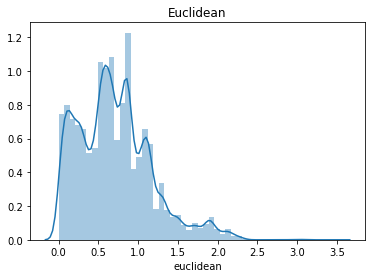

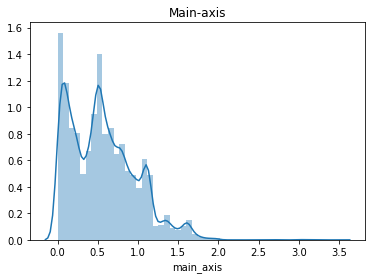

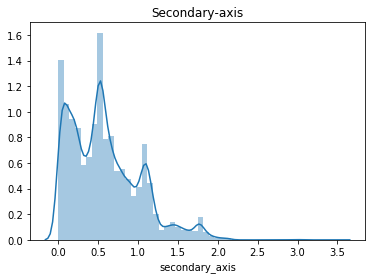

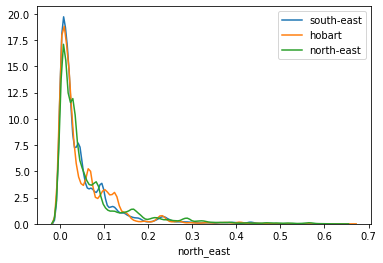

In [34]:
sns.distplot(np.log1p(combined_quakes[combined_quakes.south_east < 0.5].euclidean))
plt.title("Euclidean")
plt.show()

sns.distplot(np.log1p(combined_quakes[combined_quakes.south_east < 0.5].main_axis))
plt.title("Main-axis")
plt.show()

sns.distplot(np.log1p(combined_quakes[combined_quakes.south_east < 0.5].secondary_axis))
plt.title("Secondary-axis")
plt.show()

sns.distplot(combined_quakes[combined_quakes.south_east < 0.5].south_east, hist=False, label = 'south-east')
sns.distplot(combined_quakes[combined_quakes.south_east < 0.5].hobart, hist = False, label = 'hobart')
sns.distplot(combined_quakes[combined_quakes.south_east < 0.5].north_east, hist = False, label = 'north-east')
plt.legend()
plt.show()

All three of these metrics tell the same story: that reported locations are usually near to the official locations. I suspect that if we were to plot these three metrics together, that they would be closely correlated:

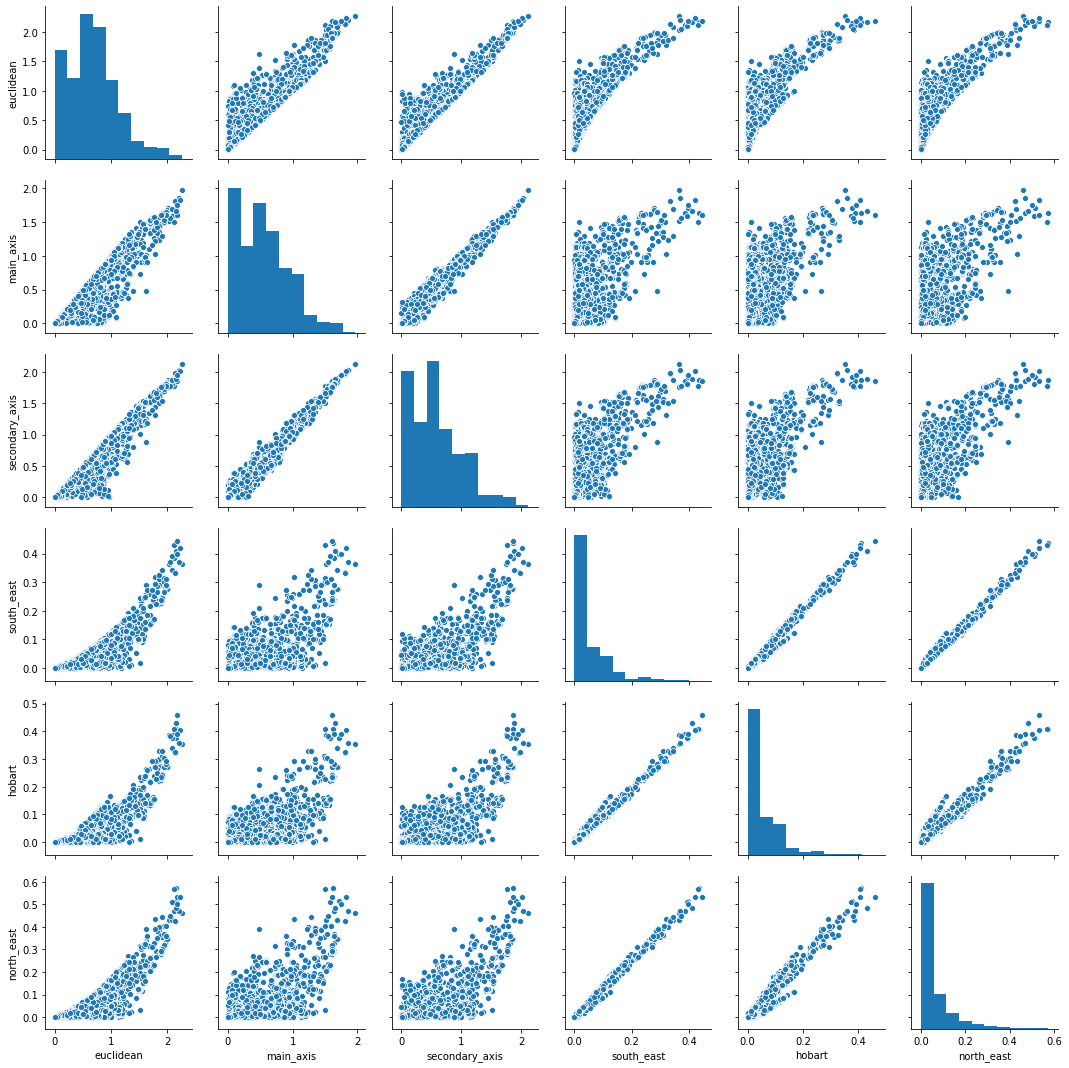

array([[1.   , 0.902, 0.934, 0.812, 0.812, 0.793],
       [0.902, 1.   , 0.978, 0.572, 0.599, 0.535],
       [0.934, 0.978, 1.   , 0.641, 0.642, 0.623],
       [0.812, 0.572, 0.641, 1.   , 0.983, 0.988],
       [0.812, 0.599, 0.642, 0.983, 1.   , 0.942],
       [0.793, 0.535, 0.623, 0.988, 0.942, 1.   ]])

In [36]:
sample_data = combined_quakes[combined_quakes.south_east < 0.5].sample(frac = 0.05)[['euclidean', 'main_axis', 'secondary_axis', 'south_east', 'hobart', 'north_east']]
sample_data['euclidean'] = np.log1p(sample_data.euclidean)
sample_data['main_axis'] = np.log1p(sample_data.main_axis)
sample_data['secondary_axis'] = np.log1p(sample_data.secondary_axis)

sns.pairplot(sample_data)
plt.show()


np.round(
    np.corrcoef(
        np.transpose(sample_data)
    ),
    3
)

No surprises there, that these distances all show reasonable correlation. Interestingly, the main_axis dimension isn't as correlated with the angle as I thought it would be. And, the differences between euclidean distance and the main_axis distance will reflect the east-west spread of points.

Let's see how these correlate with magnitude and depth:

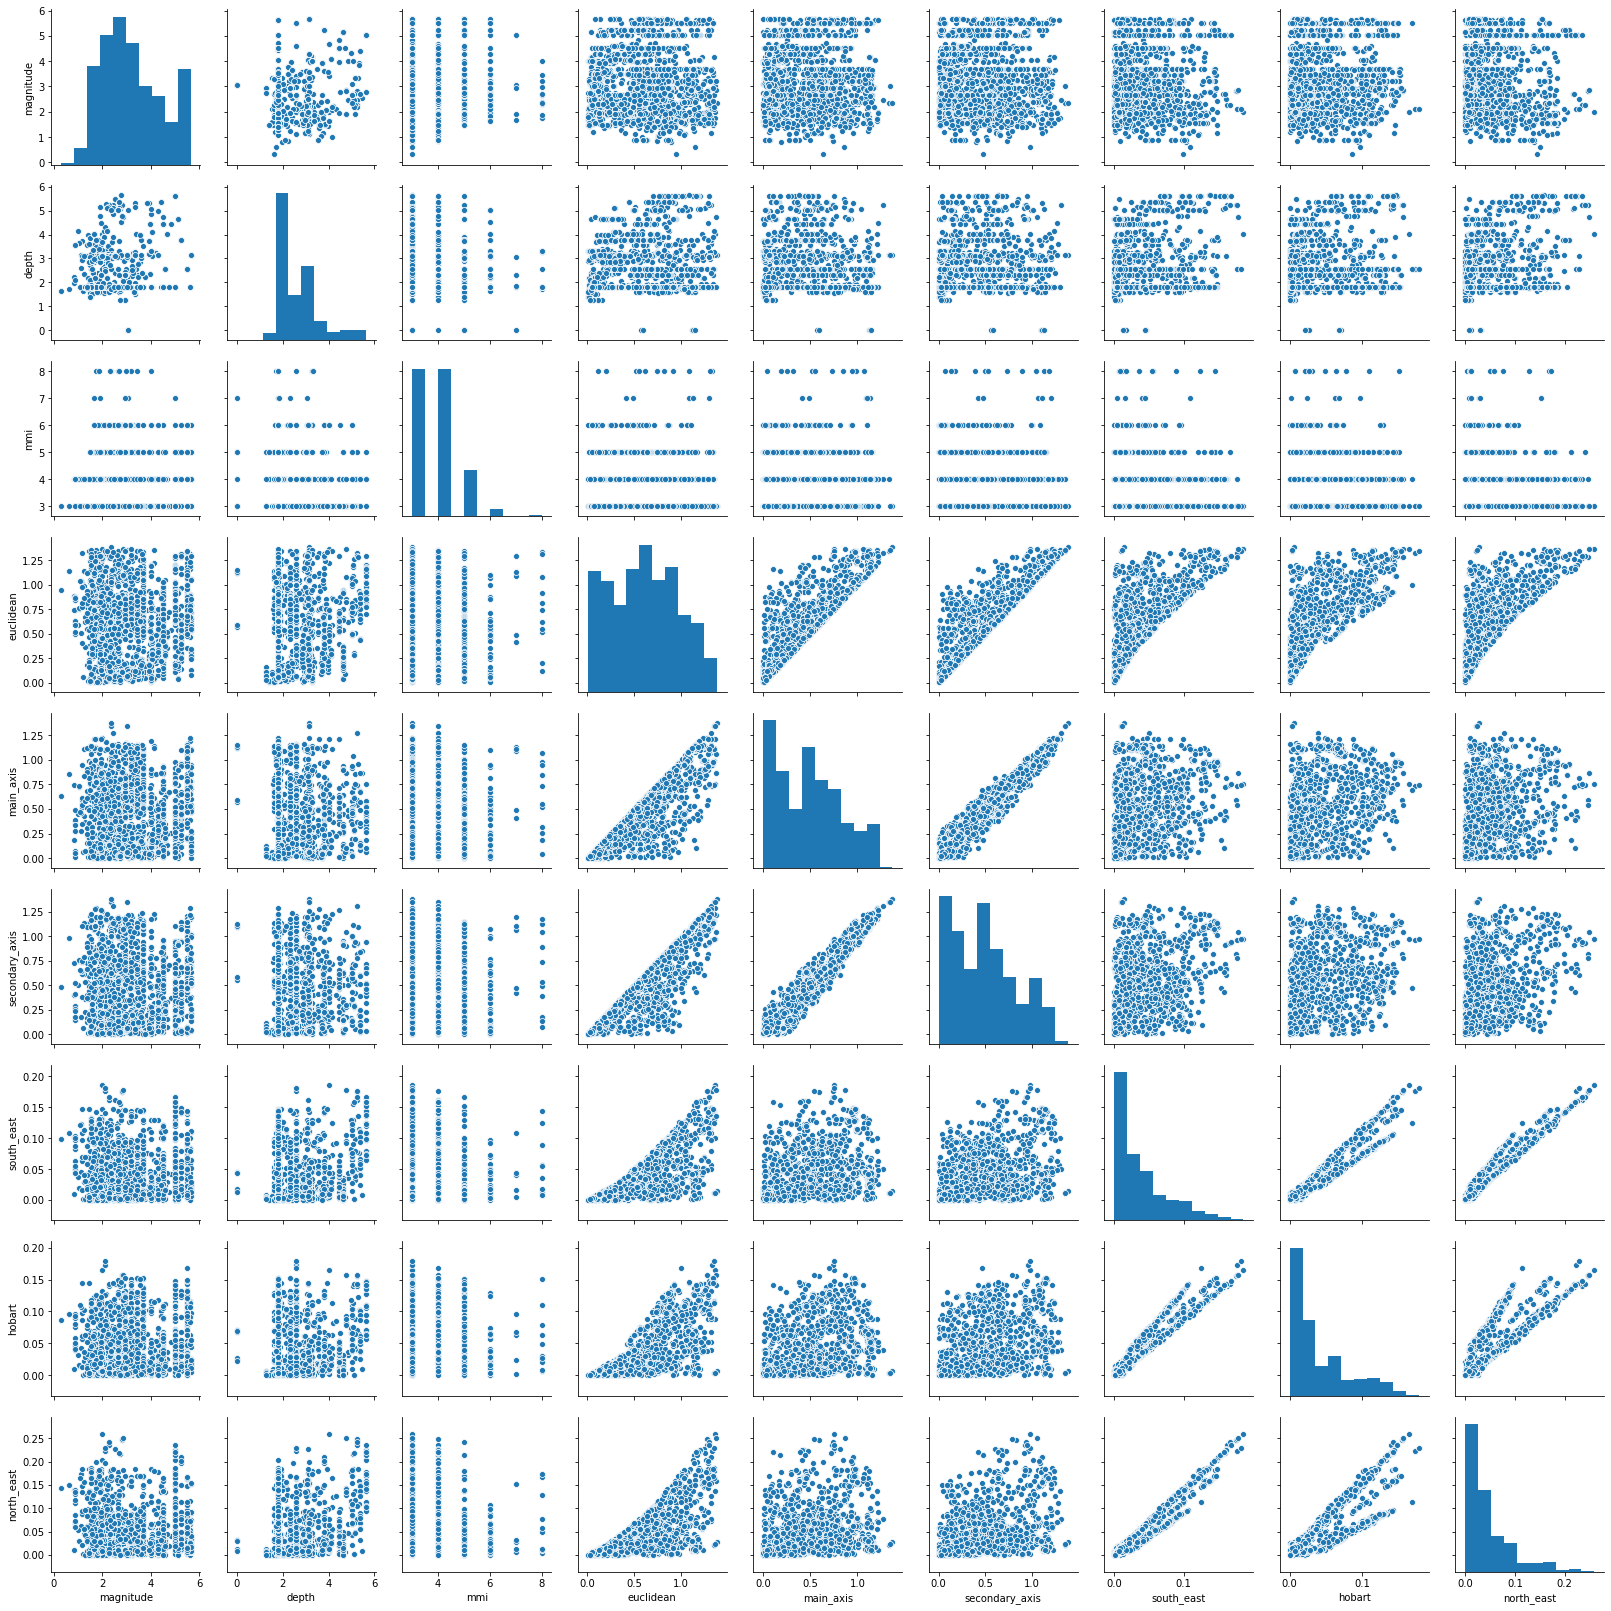

In [38]:
sample_data = combined_quakes.query('south_east < 0.5 & euclidean < 3')\
    .sample(frac = 0.05)[['magnitude', 'depth', 'mmi', 'euclidean', 'main_axis', 'secondary_axis', 'south_east', 'hobart', 'north_east']]
sample_data['depth'] = np.log1p(sample_data.depth)
sample_data['euclidean'] = np.log1p(sample_data.euclidean)
sample_data['main_axis'] = np.log1p(sample_data.main_axis)
sample_data['secondary_axis'] = np.log1p(sample_data.secondary_axis)

sns.pairplot(sample_data)
plt.show()

That's a shame - there are no obvious correlation between these distance metrics and the size/depth of a quake. 

Let's see what this looks like, broken down into regions. I will remove Auckland and Otago, as these have so few official quakes.

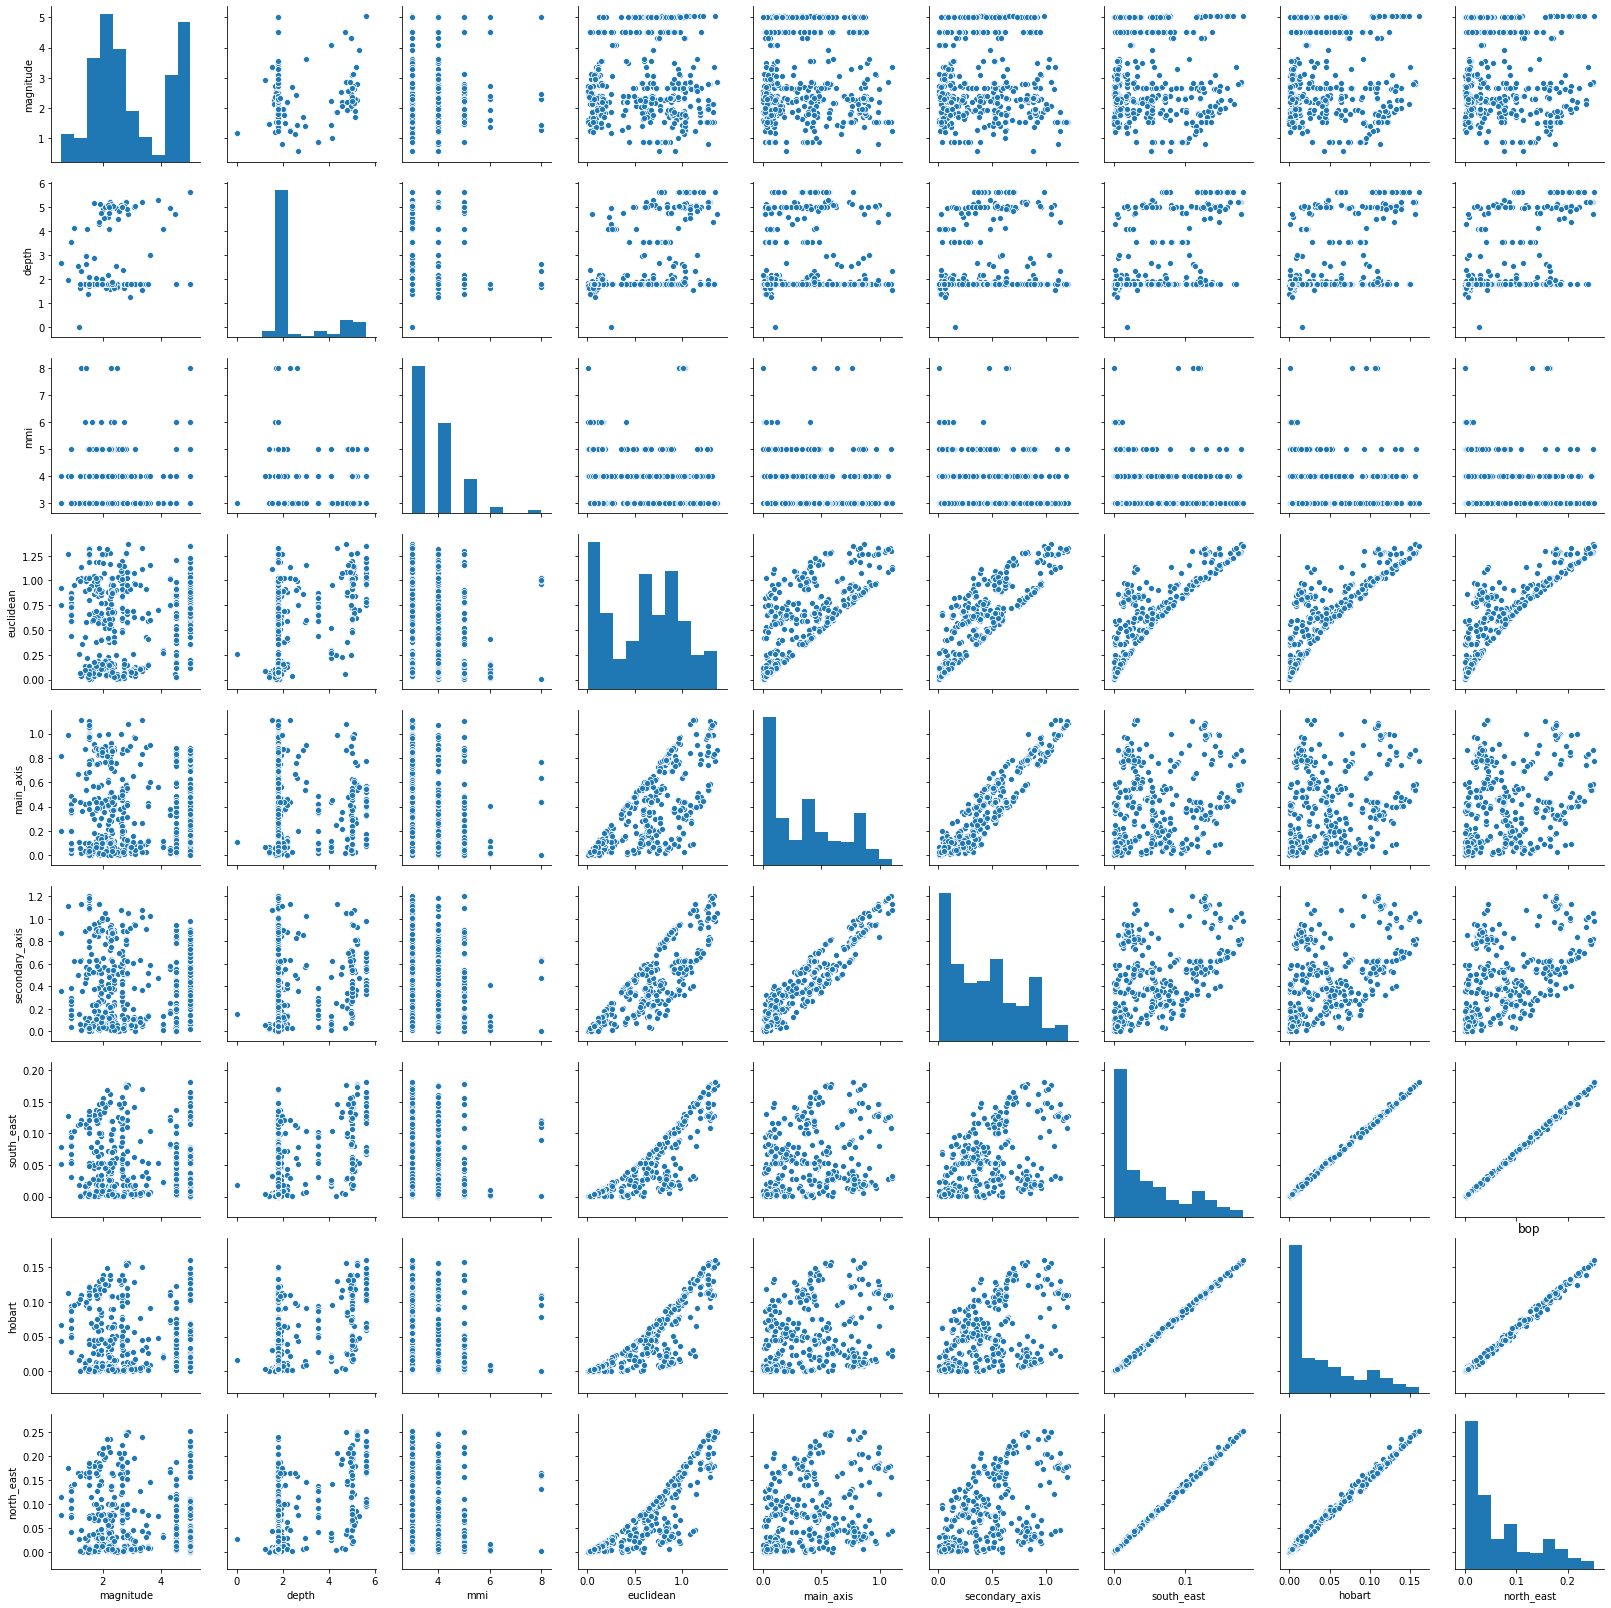

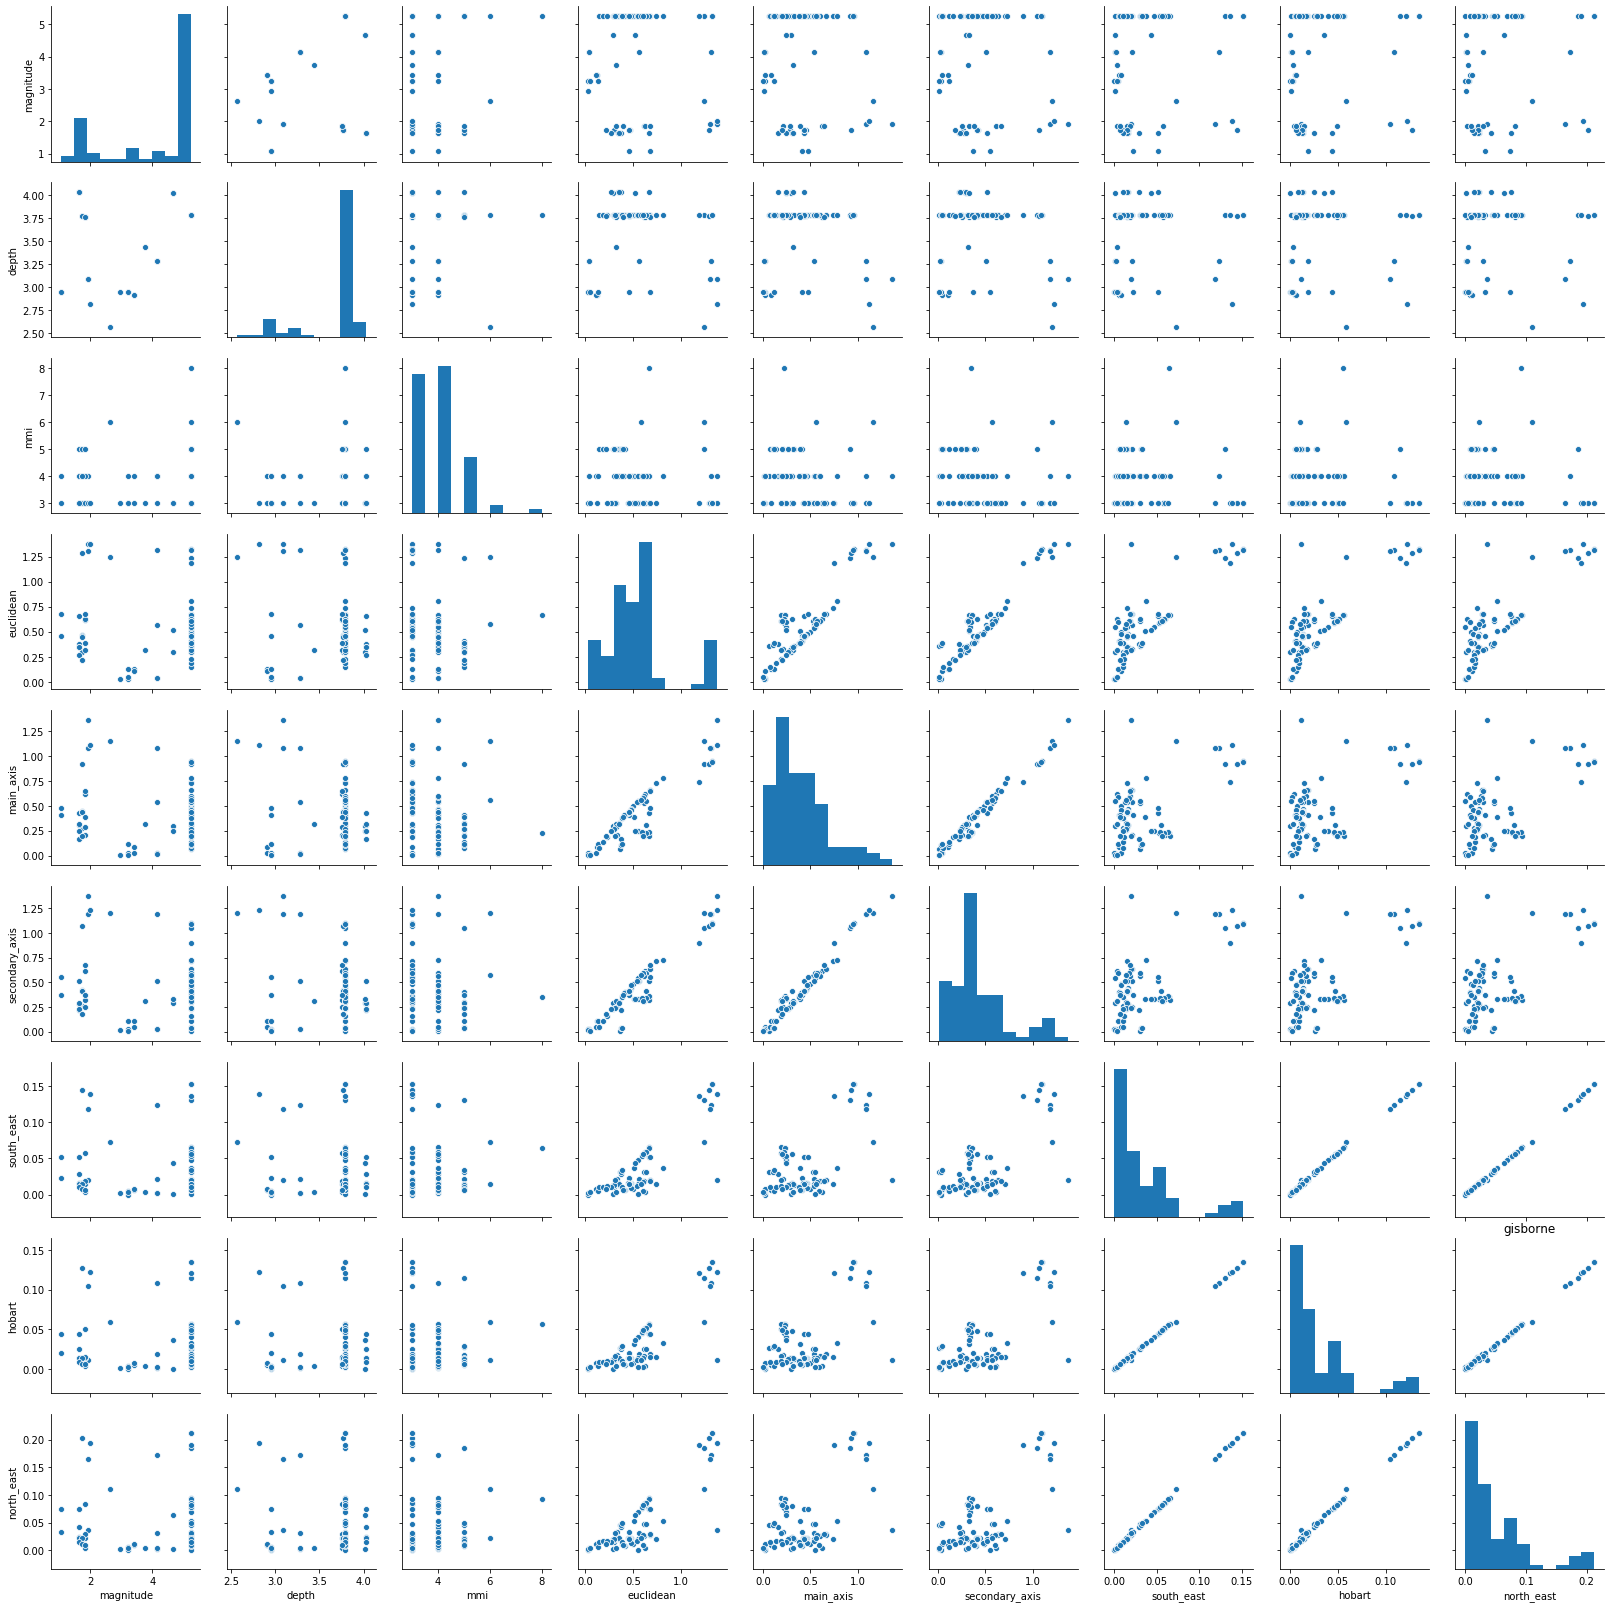

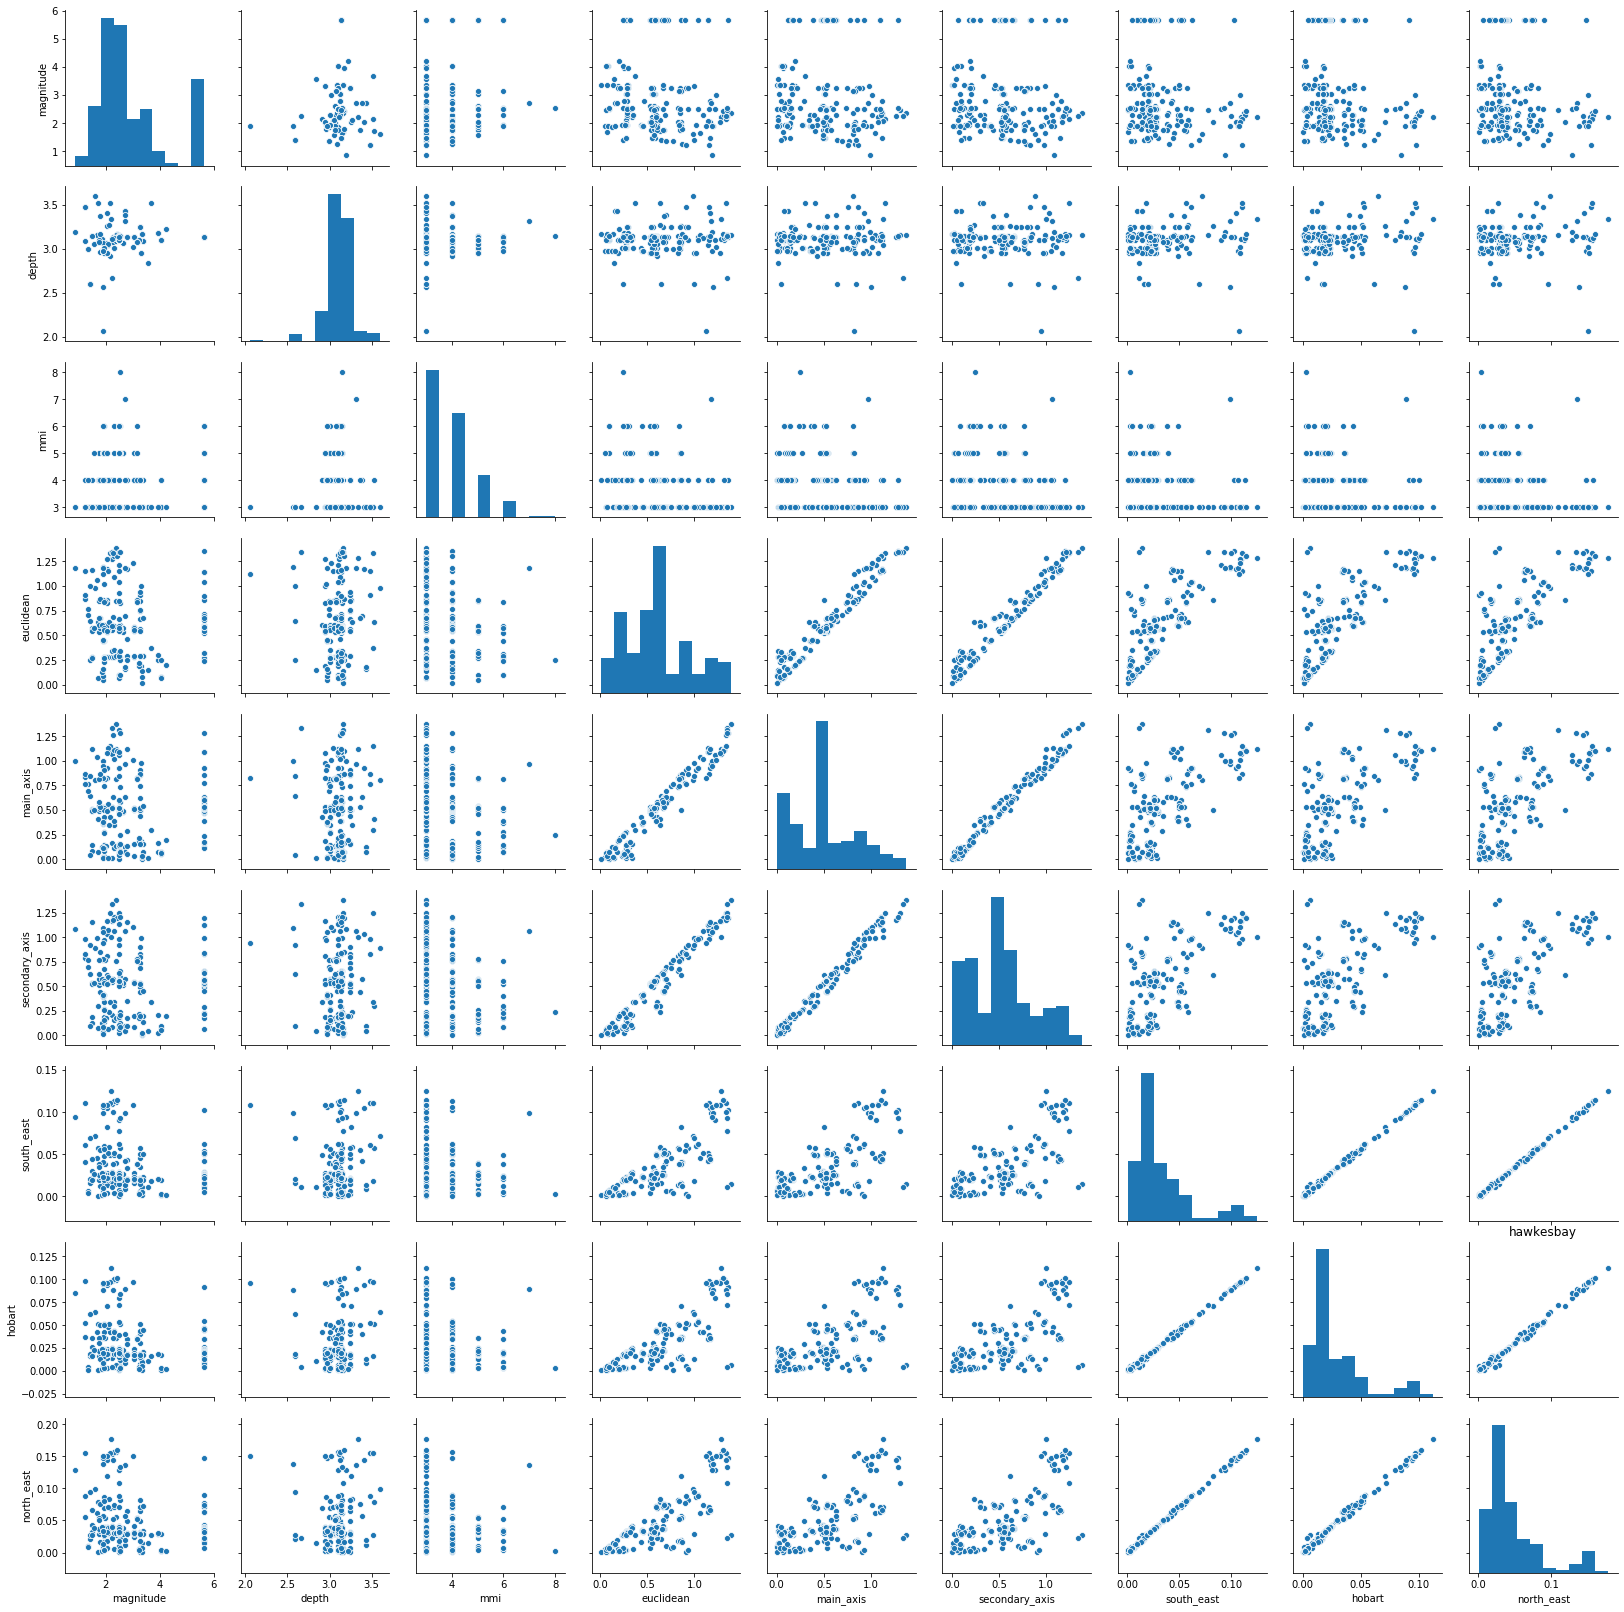

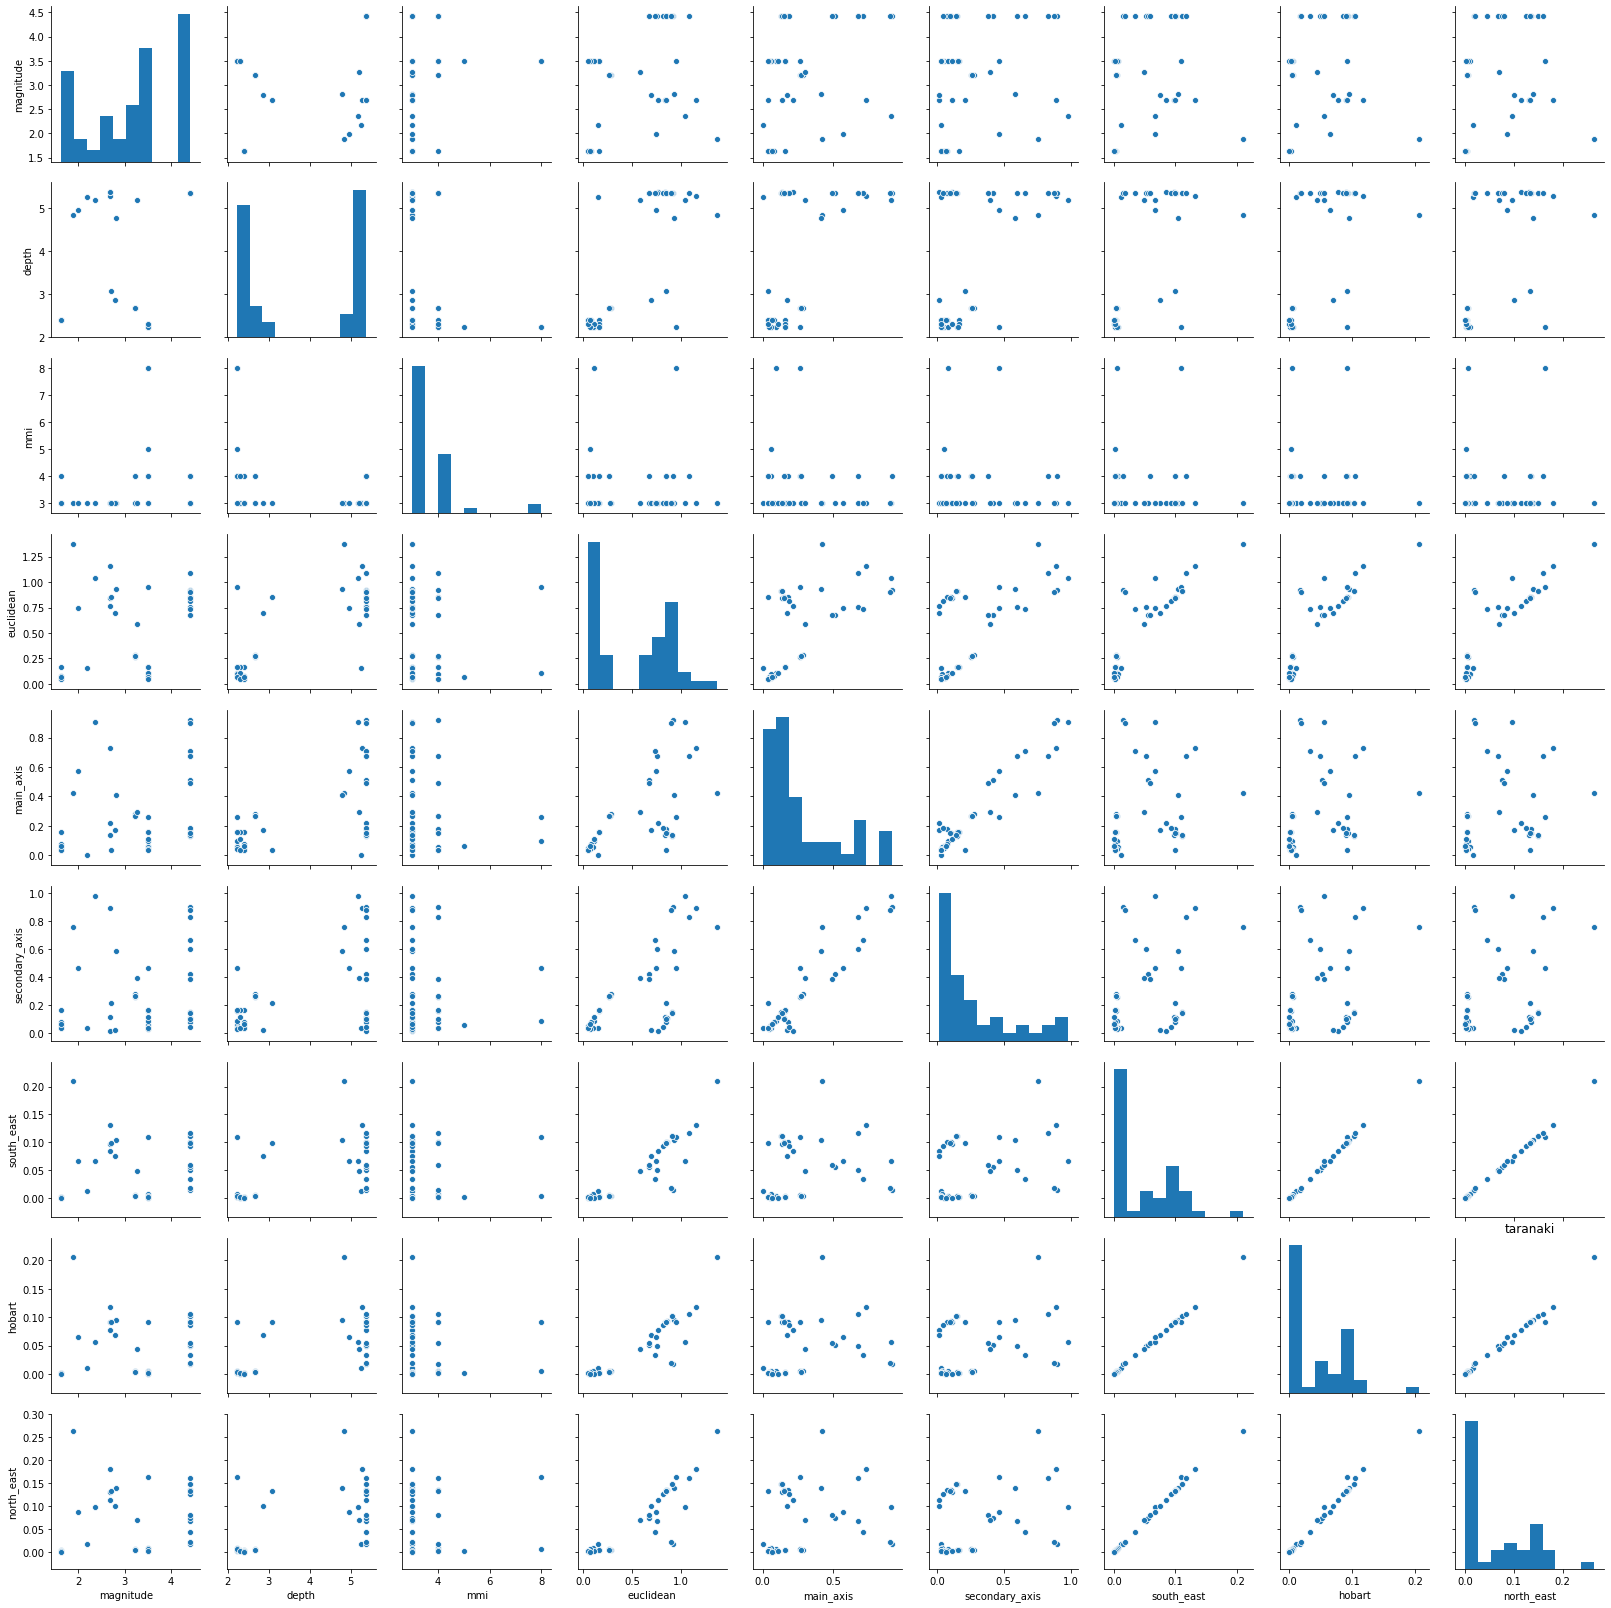

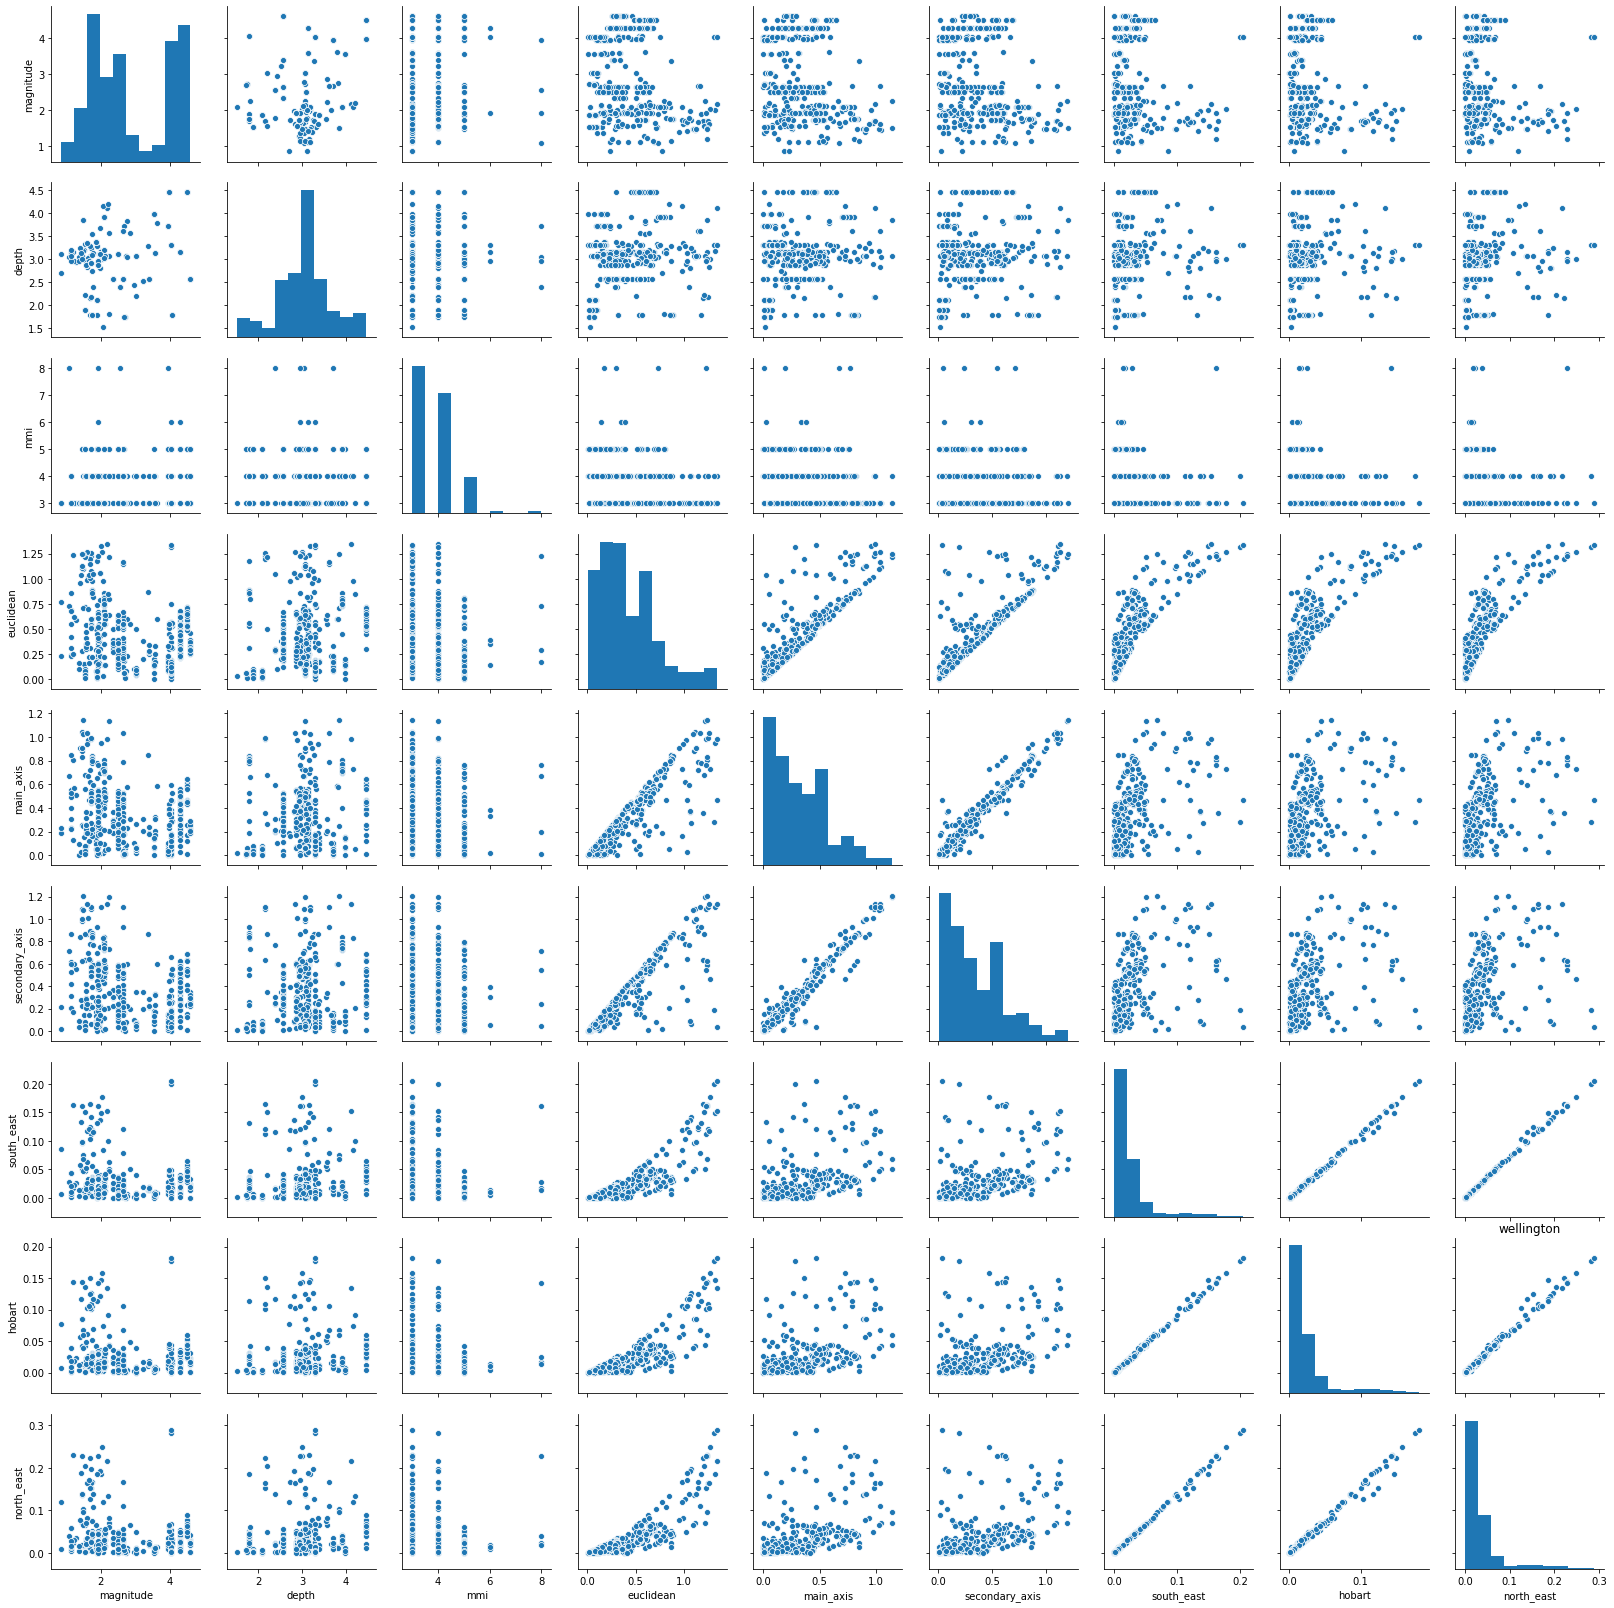

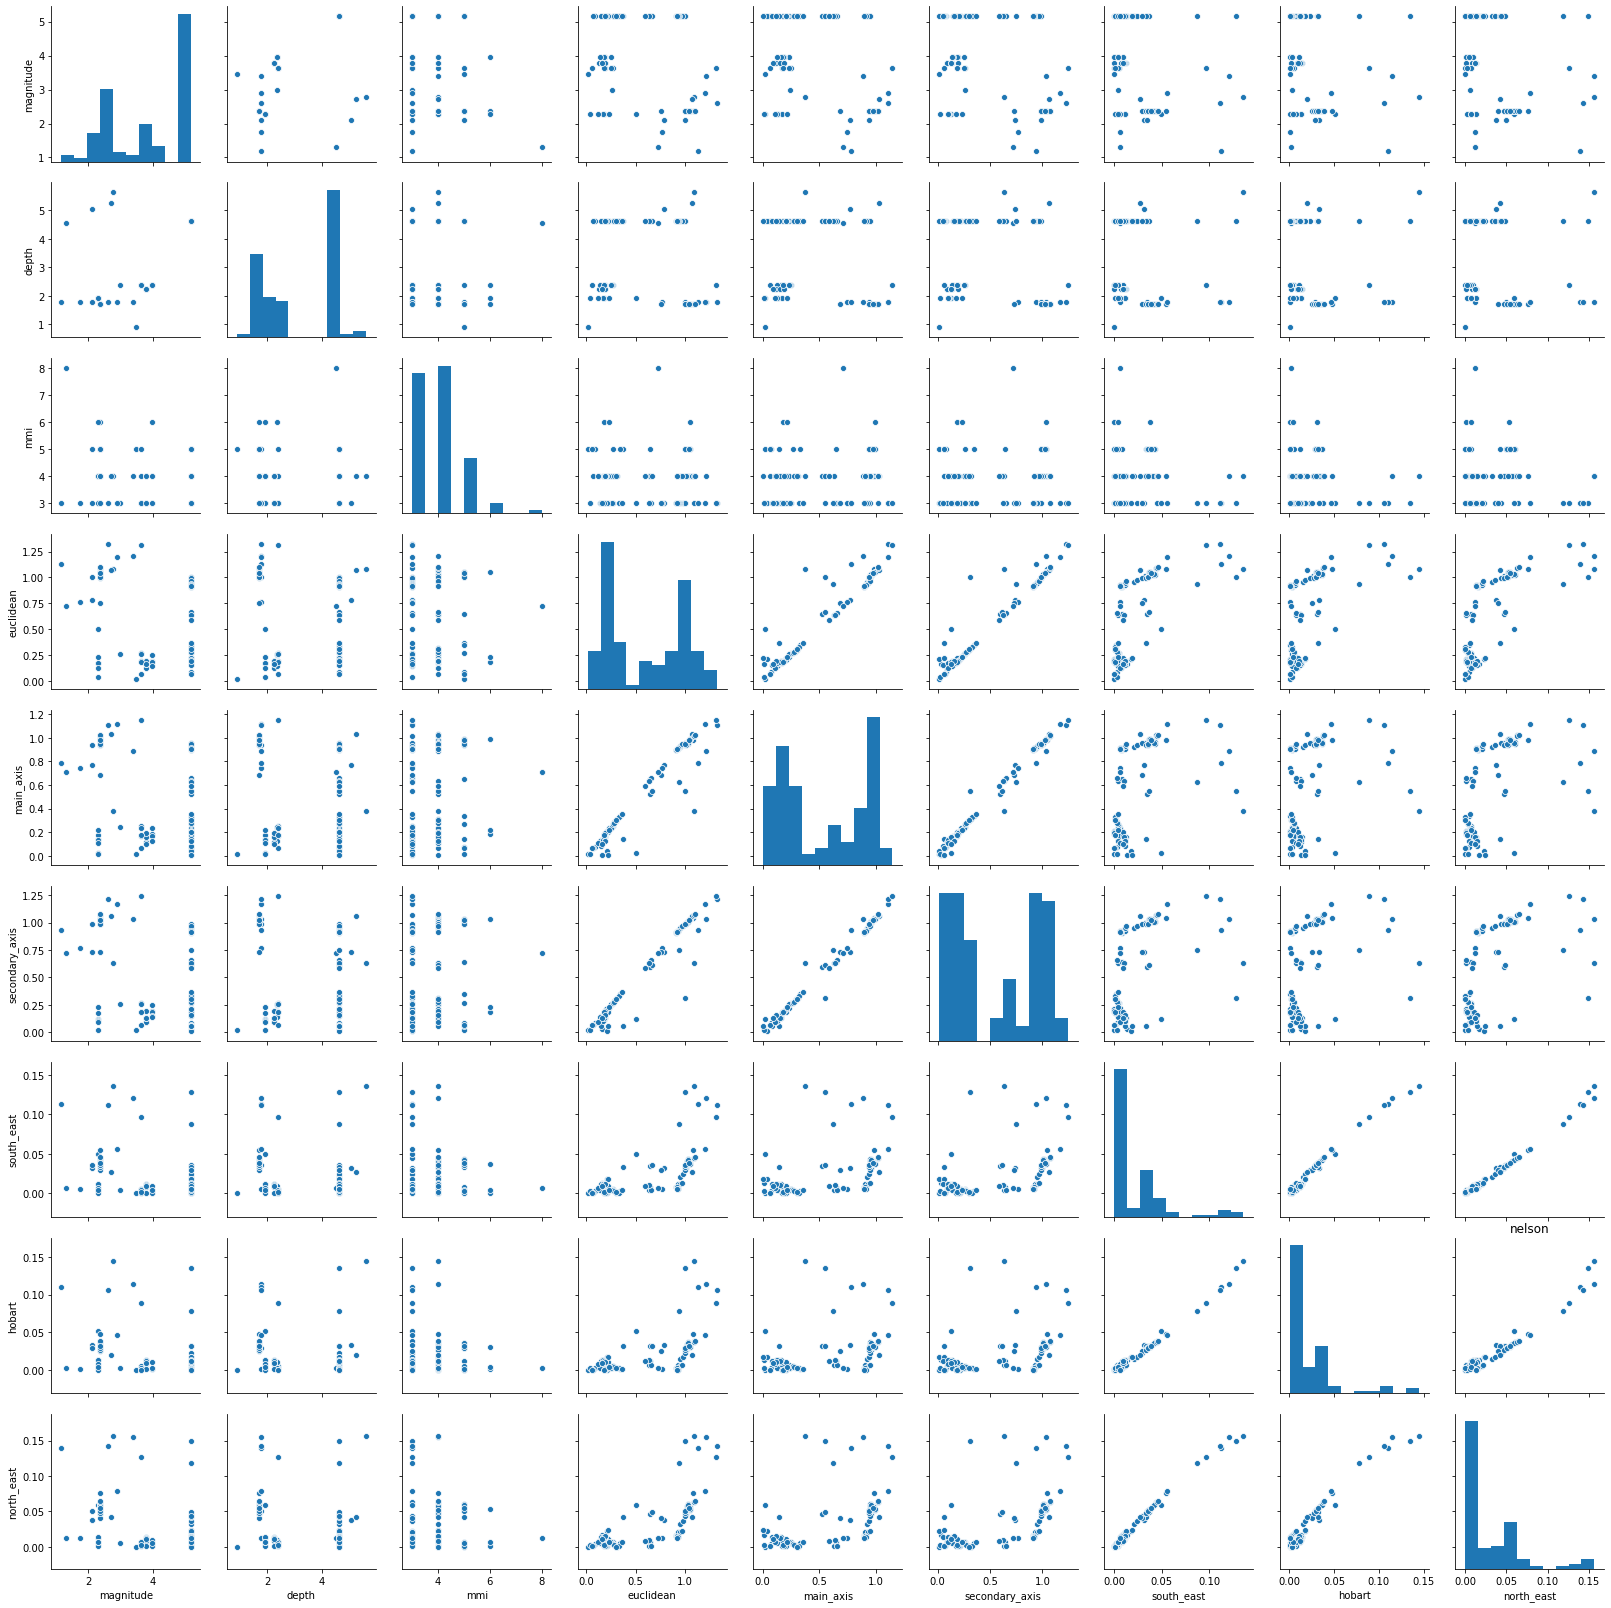

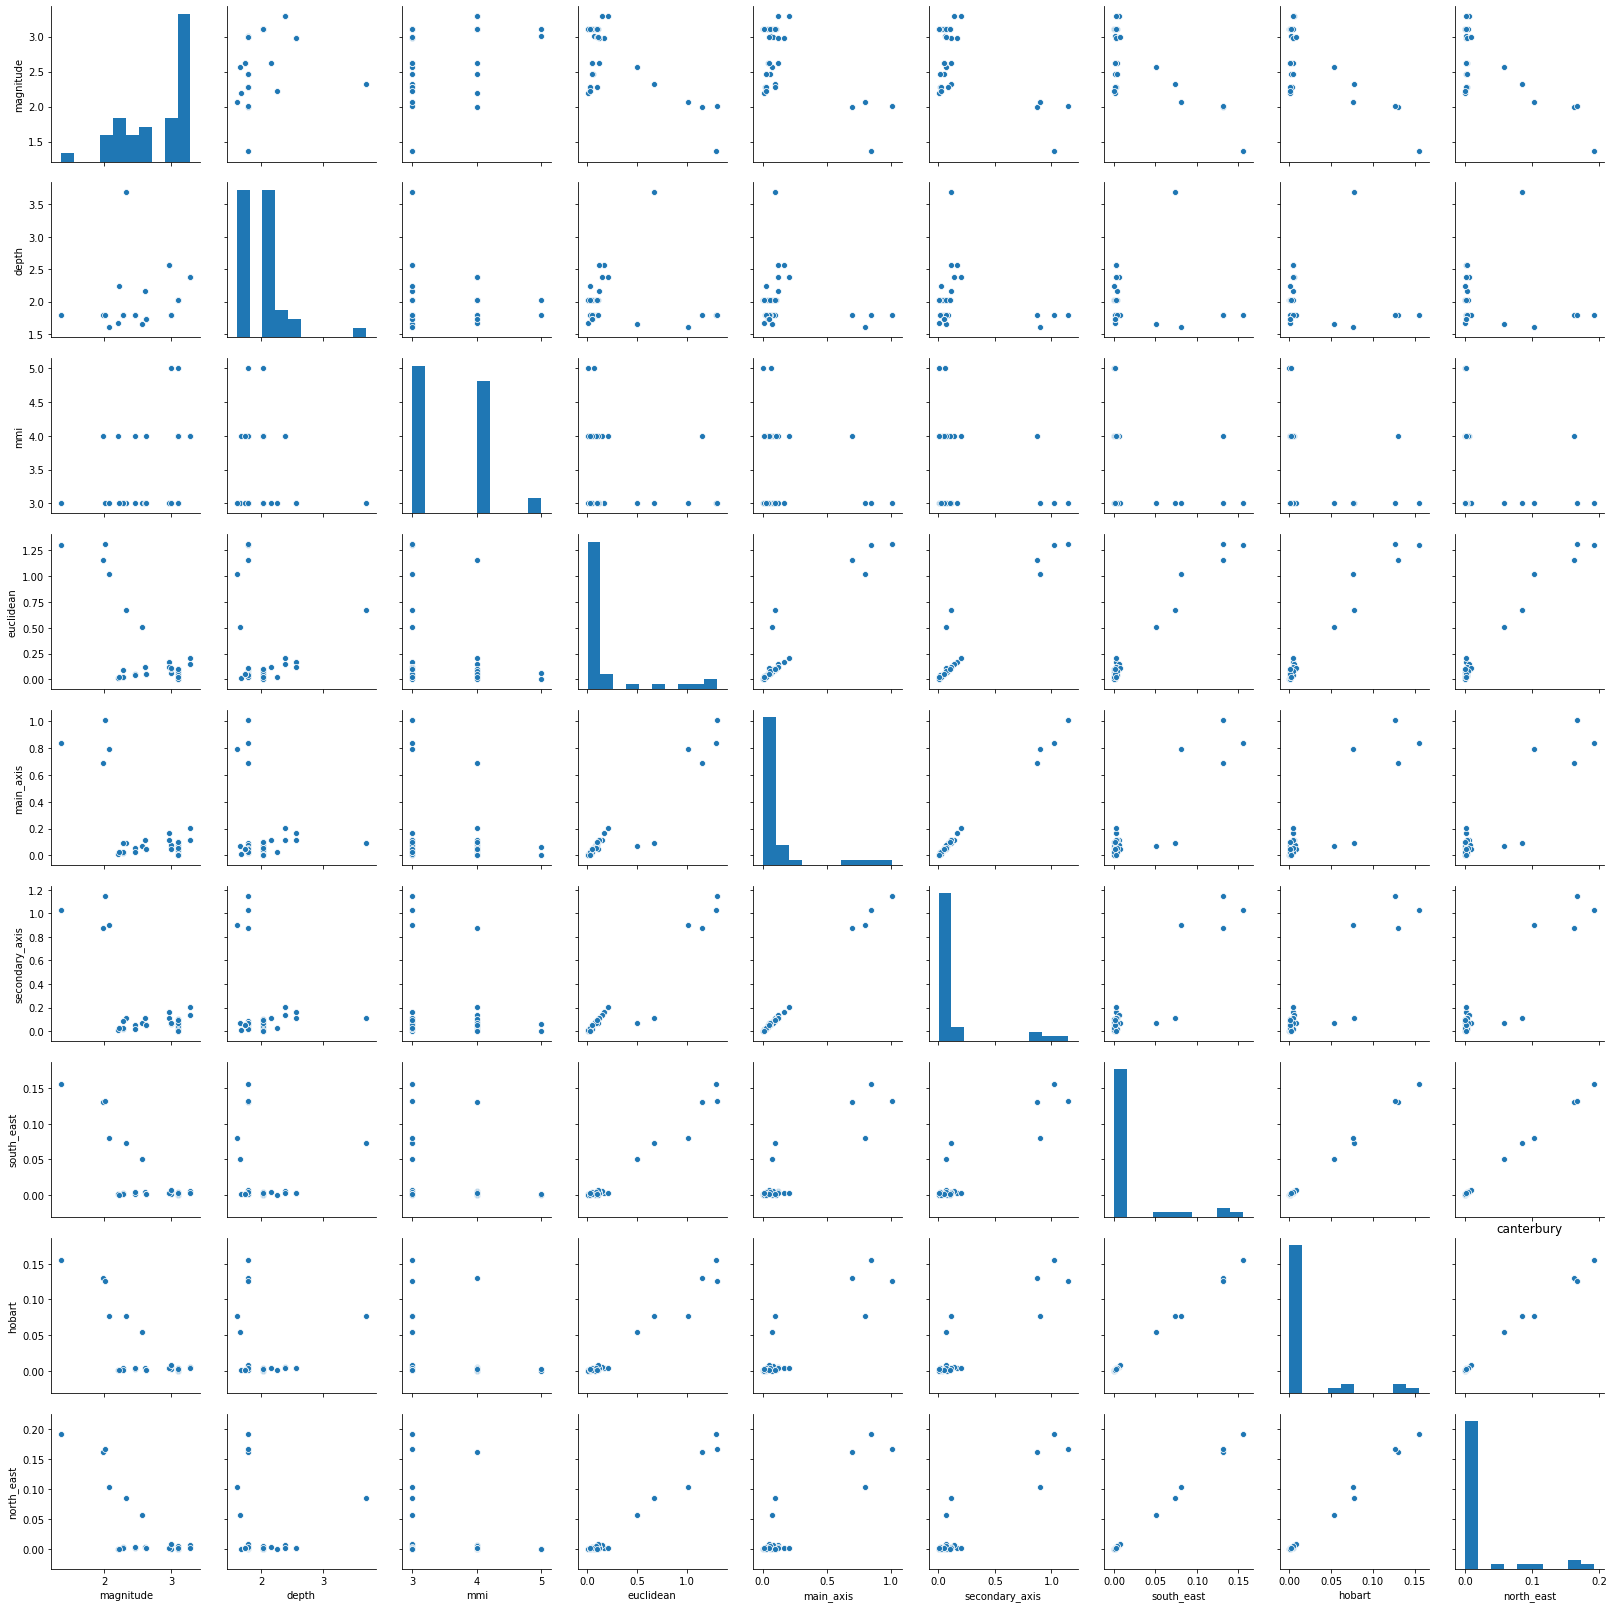

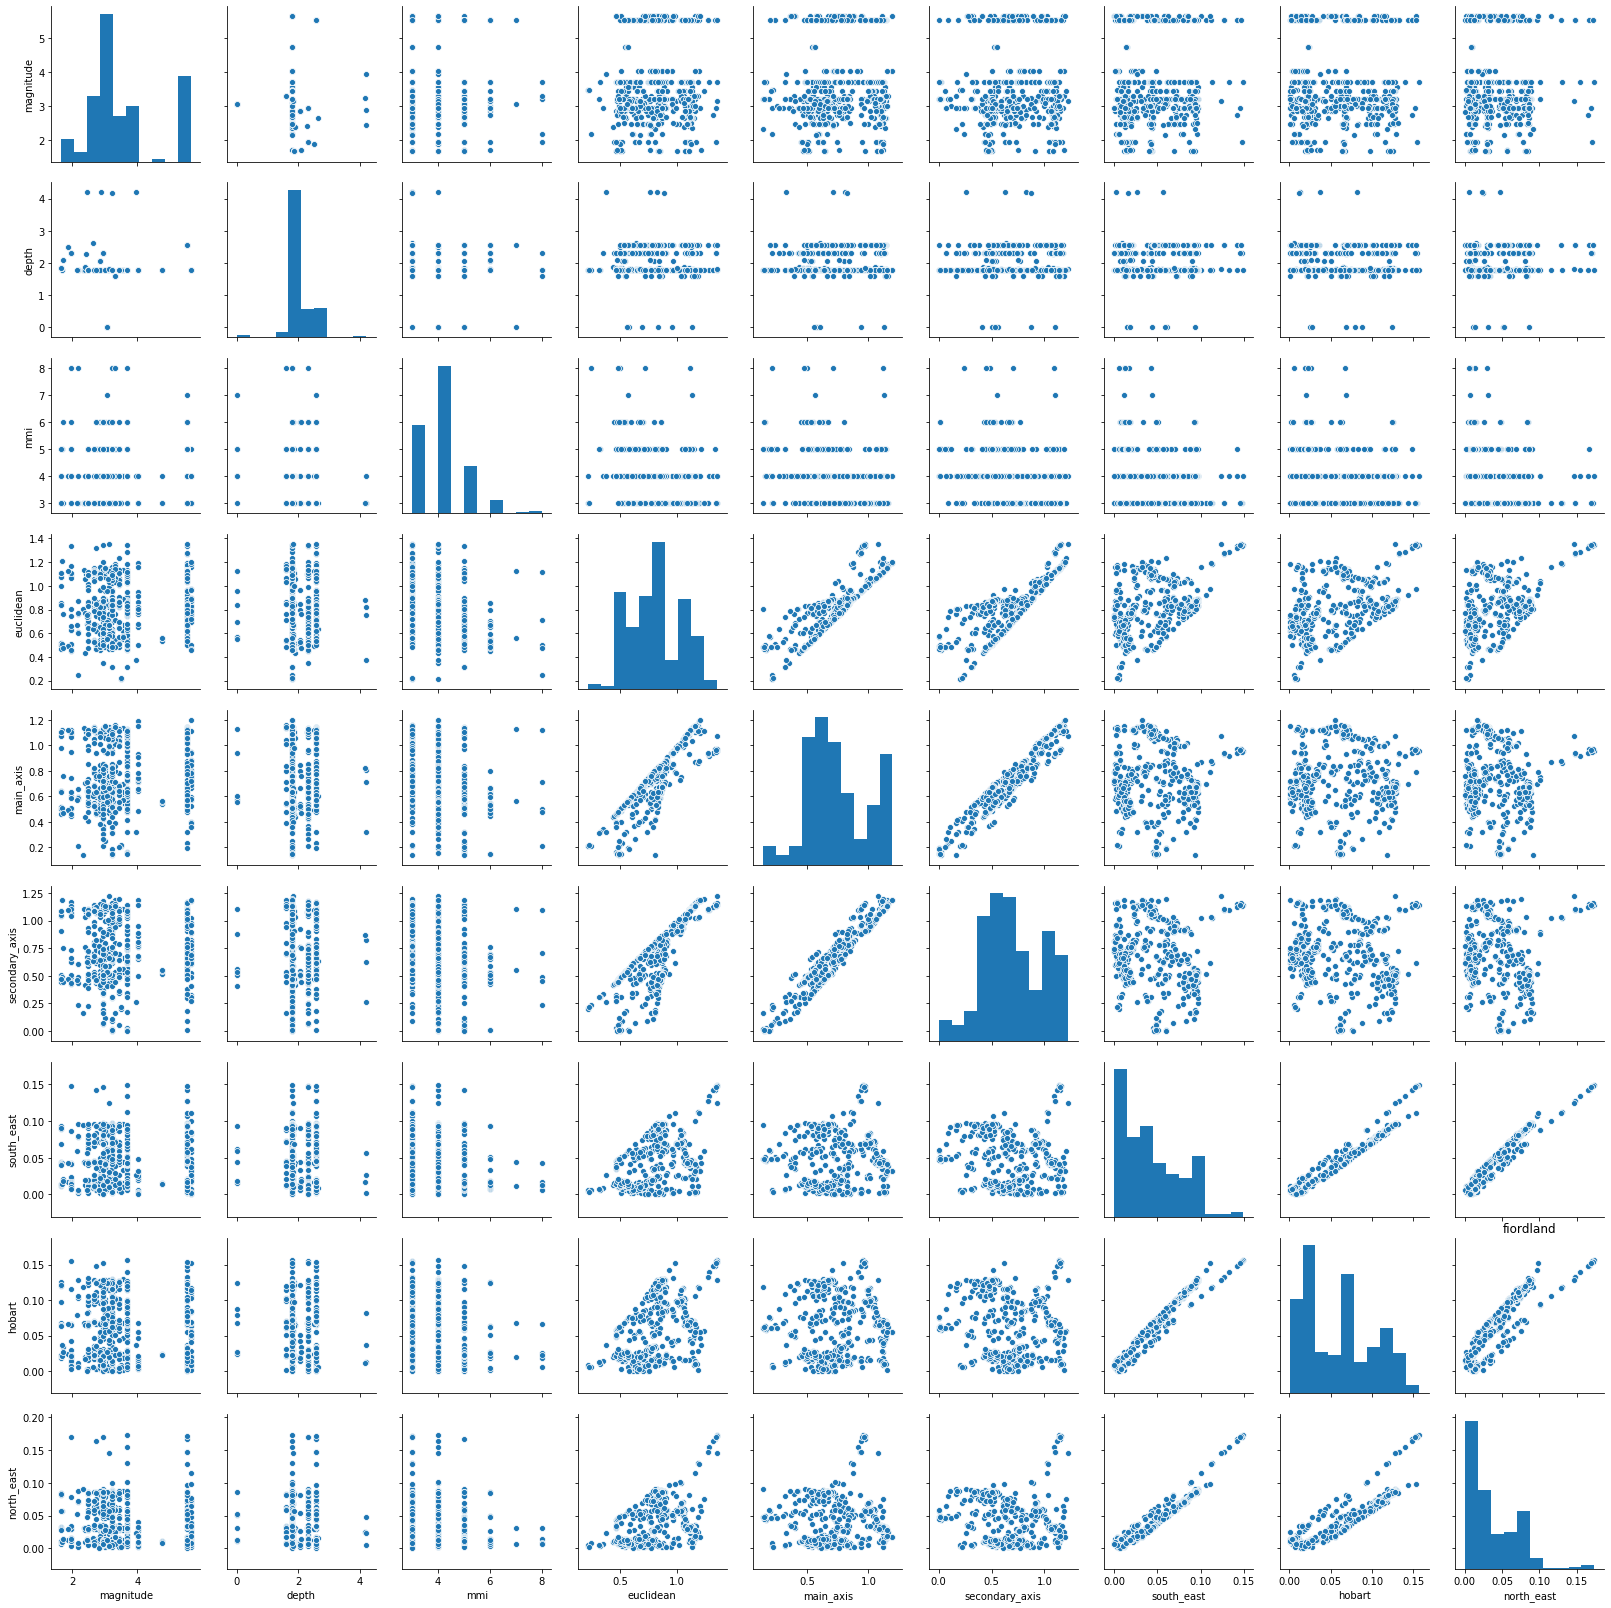

In [39]:
for x in regions:

  if x not in ['auckland', 'otago']:
    sample_data = combined_quakes.query("region == '{}' & south_east < 0.5 & euclidean < 3".format(x))\
        .sample(frac = 0.05)[['magnitude', 'depth', 'mmi', 'euclidean', 'main_axis', 'secondary_axis', 'south_east', 'hobart', 'north_east']]
    sample_data['depth'] = np.log1p(sample_data.depth)
    sample_data['euclidean'] = np.log1p(sample_data.euclidean)
    sample_data['main_axis'] = np.log1p(sample_data.main_axis)
    sample_data['secondary_axis'] = np.log1p(sample_data.secondary_axis)

    sns.pairplot(sample_data)
    plt.title(x)
    plt.show()

There are certainly some subtle differences between regions with respect to the magnitude of quakes. 

There is a subtle correlation between the angle and the reported strength (mmi). As the angle increases, i.e. there is more distance between the quake and the reportee, the reported mmi decreases accordingly. This is good, it is an intuitive interpretation.

The three angles I calculated are almost perfectly correlated, so we don't need all of them. I will run with the Chatham angle - let's visualise this by region.

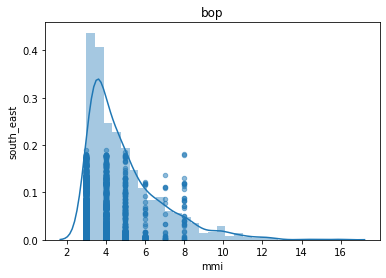

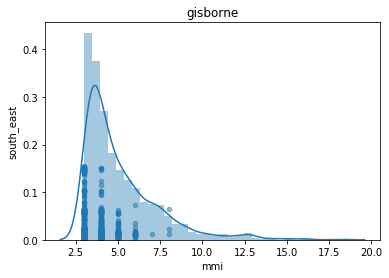

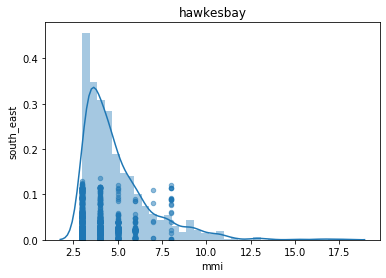

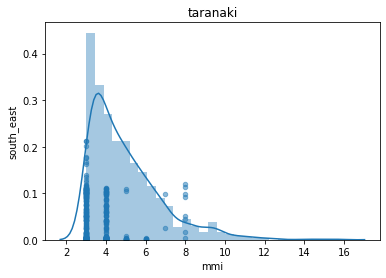

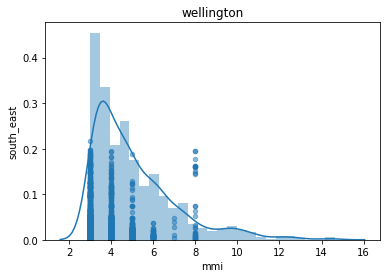

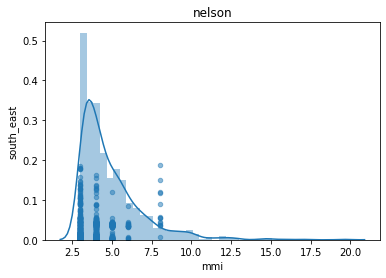

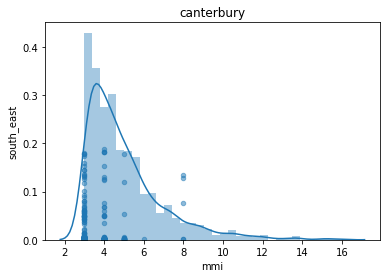

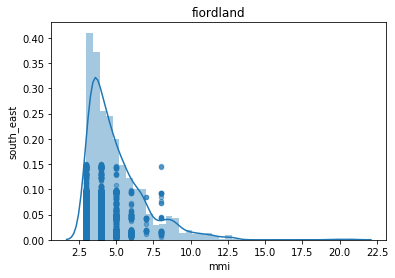

In [43]:
for x in regions:

  if x not in ['auckland', 'otago']:
    sample_data = combined_quakes.query("region == '{}' & south_east < 0.5 & euclidean < 3".format(x))\
        .sample(frac = 0.5)[['mmi', 'south_east']]

    sample_data.plot.scatter('mmi', 'south_east', alpha=0.5)
    sns.distplot(np.random.chisquare(2,size=1000)+3)
    plt.title(x)
    plt.show()

This is interesting - and aligns with my intuition here nicely. Consider that the reported locations contain a good amount of error (due to inaccuracies in the data collection method). But there is a pretty clear trend here: 

```
the reported strength (mmi) is proportional to the distance that the reportee is from the official coordinates of the quake. 

The reported strength decreases over distance.
```  

I think this is quite cool. We could potentially model this relationship and derive credibility scores for reported quakes/locations. We could increase the credibility of reports which fall within expected ranges and equally, decrease the credibility of reports where the reported strength seems too high or where the location seems to be out.  

This scenario is possibly a little contrived. Do we really care this much about these public quake reports? Possibly not, we'd hope that we would get enough public reports that anomalies are minimised/drowned by good-quality reports. 

But if we think a little more laterally, we could imagine other scenarios where something like this might be useful. We could use similar ideas to calibrate quality/performance metrics in production/manufacturing, even in business performance. The general idea here is quite widely applicable.